<a href="https://colab.research.google.com/github/berberberk/bird-species-classification-py/blob/main/bird_species_classification_v25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

# Импорт библиотек

In [20]:
!pip install keras_preprocessing

In [21]:
!pip install tensorflow==2.18.0

In [22]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import img_to_array, plot_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

from pathlib import Path
import os.path
import datetime
import random

import matplotlib.cm as cm
import cv2
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import itertools


# Импорт датасета

In [23]:
#@title Импорт датасета CUB-200-2011

import kagglehub
import os.path

# Download latest version
path = kagglehub.dataset_download("wenewone/cub2002011")

print("Path to dataset files:", path)

path = os.path.join(path, 'CUB_200_2011')

Path to dataset files: /kaggle/input/cub2002011


In [24]:
df_img = pd.read_csv(os.path.join(path, 'images.txt'), sep=' ', header=None, names=['ID', 'Image'], index_col=0)
df_label = pd.read_csv(os.path.join(path, 'image_class_labels.txt'), sep=' ', header=None, names=['ID', 'Label'], index_col=0)

df = pd.concat([df_img, df_label], axis=1)

df.head()

Image  Label
ID                                                          
1   001.Black_footed_Albatross/Black_Footed_Albatr...      1
2   001.Black_footed_Albatross/Black_Footed_Albatr...      1
3   001.Black_footed_Albatross/Black_Footed_Albatr...      1
4   001.Black_footed_Albatross/Black_Footed_Albatr...      1
5   001.Black_footed_Albatross/Black_Footed_Albatr...      1

In [25]:
df['Path'] = df['Image'].apply(lambda x: os.path.join(path, 'images', x))
df['Species'] = df['Image'].apply(lambda x: re.findall("\d+\.(\w+)", x)[0].replace('_', ' '))


print('Размер датасета: ', df.shape)
df.head()

Размер датасета:  (11788, 4)


Image  Label  \
ID                                                             
1   001.Black_footed_Albatross/Black_Footed_Albatr...      1   
2   001.Black_footed_Albatross/Black_Footed_Albatr...      1   
3   001.Black_footed_Albatross/Black_Footed_Albatr...      1   
4   001.Black_footed_Albatross/Black_Footed_Albatr...      1   
5   001.Black_footed_Albatross/Black_Footed_Albatr...      1   

                                                 Path                 Species  
ID                                                                             
1   /kaggle/input/cub2002011/CUB_200_2011/images/0...  Black footed Albatross  
2   /kaggle/input/cub2002011/CUB_200_2011/images/0...  Black footed Albatross  
3   /kaggle/input/cub2002011/CUB_200_2011/images/0...  Black footed Albatross  
4   /kaggle/input/cub2002011/CUB_200_2011/images/0...  Black footed Albatross  
5   /kaggle/input/cub2002011/CUB_200_2011/images/0...  Black footed Albatross

In [26]:
df.isnull().sum()

Image      0
Label      0
Path       0
Species    0
dtype: int64

In [27]:
for col in df.columns.tolist():
    print(f'Уникальных значений в столбце {col}: {len(df[col].unique())}')

Уникальных значений в столбце Image: 11788
Уникальных значений в столбце Label: 200
Уникальных значений в столбце Path: 11788
Уникальных значений в столбце Species: 200


In [28]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=42, stratify=df_train['Label'])


df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


print('Размер train: ', df_train.shape)
print('Размер val: ', df_val.shape)
print('Размер test: ', df_test.shape)
df_train.head()

Размер train:  (8487, 4)
Размер val:  (943, 4)
Размер test:  (2358, 4)


Image  Label  \
0  155.Warbling_Vireo/Warbling_Vireo_0002_158319.jpg    155   
1  179.Tennessee_Warbler/Tennessee_Warbler_0084_1...    179   
2    113.Baird_Sparrow/Baird_Sparrow_0032_794553.jpg    113   
3         085.Horned_Lark/Horned_Lark_0049_74574.jpg     85   
4      145.Elegant_Tern/Elegant_Tern_0009_150954.jpg    145   

                                                Path            Species  
0  /kaggle/input/cub2002011/CUB_200_2011/images/1...     Warbling Vireo  
1  /kaggle/input/cub2002011/CUB_200_2011/images/1...  Tennessee Warbler  
2  /kaggle/input/cub2002011/CUB_200_2011/images/1...      Baird Sparrow  
3  /kaggle/input/cub2002011/CUB_200_2011/images/0...        Horned Lark  
4  /kaggle/input/cub2002011/CUB_200_2011/images/1...       Elegant Tern

In [29]:
for col in df_train.columns.tolist():
    print(f'Уникальных значений в столбце {col}: {len(df[col].unique())}')

Уникальных значений в столбце Image: 11788
Уникальных значений в столбце Label: 200
Уникальных значений в столбце Path: 11788
Уникальных значений в столбце Species: 200


# Просмотр изображений

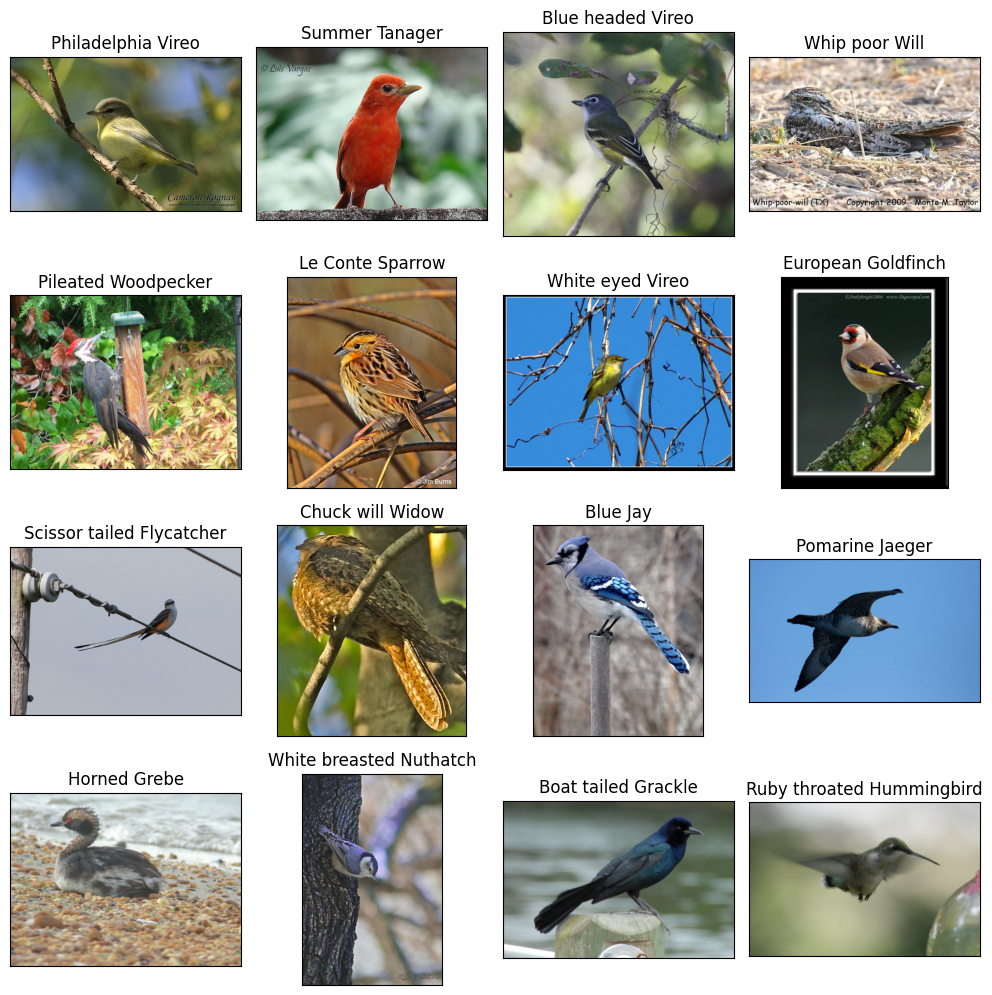

In [30]:
random_index = np.random.randint(0, len(df_train), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_train['Path'][random_index[i]]))
    ax.set_title(df_train['Species'][random_index[i]])
plt.tight_layout()
plt.show()

In [31]:
class_counts = df_train["Label"].value_counts()
class_counts.describe()

count    200.000000
mean      42.435000
std        1.976184
min       30.000000
25%       43.000000
50%       43.000000
75%       43.000000
max       43.000000
Name: count, dtype: float64

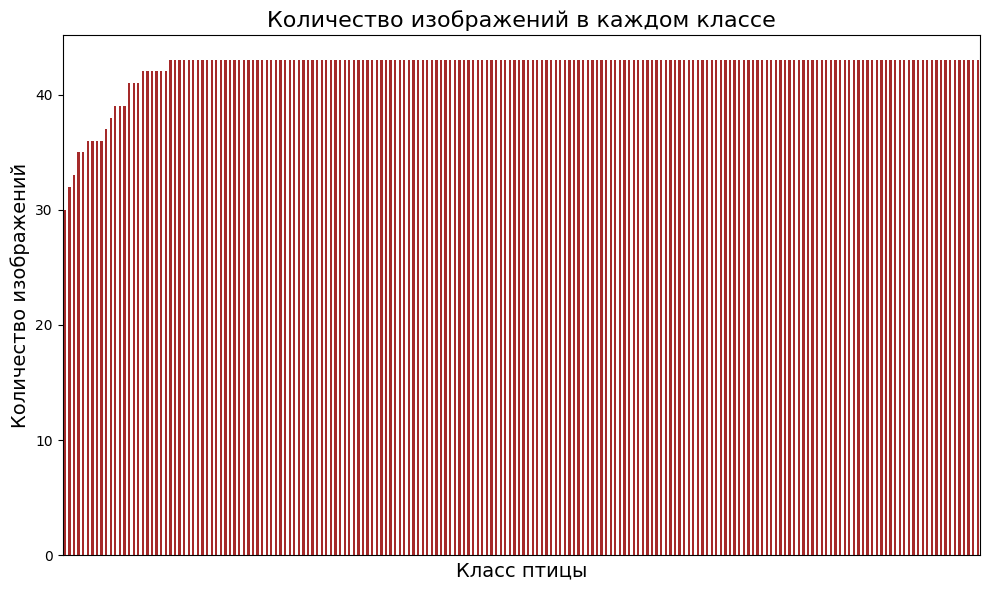

In [32]:
# Создаем гистограмму
plt.figure(figsize=(10, 6))
class_counts.sort_values().plot(kind='bar', color="brown")

plt.title("Количество изображений в каждом классе", fontsize=16)
plt.xlabel("Класс птицы", fontsize=14)
plt.ylabel("Количество изображений", fontsize=14)
plt.xticks([])
plt.tight_layout()
plt.show()

In [33]:
print(f'Самый многочисленный класс представлен в выборке в {round(class_counts.max() / class_counts.min(), 2)} раза больше, чем самый малочисленный')

Самый многочисленный класс представлен в выборке в 1.43 раза больше, чем самый малочисленный


# Аугментация изображений

Заметим, что в датасете наблюдается небольшая диспропорция классов. На это необходимо будет обратить внимание при выборе модели.

Или же можно решить эту проблему, как и проблему небольшого размера выборки,  аугментацией изображений для малопредставленных в обучающей выборке классов. Будем исходить из того, что в реальных задачах вероятность получить на вход модели фотографии разных видов птиц будет одинакова для всех классов.

Построим пайплайн для аугментации:

In [34]:
target_count = 250

# Папка для сохранения аугментированных изображений
augmented_dir = '/kaggle/working/train_aug'
os.makedirs(augmented_dir, exist_ok=True)

# Определяем генератор аугментаций
aug_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)



Напишем функцию для аугментации данных только для тех классов, количество изображений в которых меньше значения целевого параметра аугментации

In [35]:

# Итерация по всем уникальным видам птиц
for species in df_train['Species'].unique():
    # Фильтруем данные по виду
    df_class = df_train[df_train['Species'] == species]
    current_count = df_class.shape[0]
    images_needed = target_count - current_count
    if images_needed <= 0:
        continue

    print(f"Для вида '{species}' текущих изображений: {current_count}. Аугментируем {images_needed} изображений.")

    species_dir = os.path.join(augmented_dir, species)
    os.makedirs(species_dir, exist_ok=True)

    # Список путей к исходным изображениям для данного вида
    original_images = df_class['Path'].tolist()

    for i in range(images_needed):
        img_path = original_images[i % current_count]
        img = load_img(img_path)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        aug_iter = aug_datagen.flow(x, batch_size=1)
        aug_img = next(aug_iter)[0].astype(np.uint8)

        save_path = os.path.join(species_dir, f"aug_{i}.jpg")
        save_img(save_path, aug_img)

Для вида 'Warbling Vireo' текущих изображений: 43. Аугментируем 207 изображений.
Для вида 'Tennessee Warbler' текущих изображений: 43. Аугментируем 207 изображений.
Для вида 'Baird Sparrow' текущих изображений: 36. Аугментируем 214 изображений.
Для вида 'Horned Lark' текущих изображений: 43. Аугментируем 207 изображений.
Для вида 'Elegant Tern' текущих изображений: 43. Аугментируем 207 изображений.
Для вида 'Pomarine Jaeger' текущих изображений: 43. Аугментируем 207 изображений.
Для вида 'Pine Warbler' текущих изображений: 43. Аугментируем 207 изображений.
Для вида 'Rose breasted Grosbeak' текущих изображений: 43. Аугментируем 207 изображений.
Для вида 'White throated Sparrow' текущих изображений: 43. Аугментируем 207 изображений.
Для вида 'Pelagic Cormorant' текущих изображений: 43. Аугментируем 207 изображений.
Для вида 'Blue winged Warbler' текущих изображений: 43. Аугментируем 207 изображений.
Для вида 'Pacific Loon' текущих изображений: 43. Аугментируем 207 изображений.
Для вида '

In [36]:
augmented_data = []
for species in os.listdir(augmented_dir):
    species_path = os.path.join(augmented_dir, species)
    if os.path.isdir(species_path):
        for filename in os.listdir(species_path):
            file_path = os.path.join(species_path, filename)
            augmented_data.append({'Path': file_path, 'Species': species})

df_aug = pd.DataFrame(augmented_data)
print("Аугментированных изображений:", df_aug.shape[0])

# Объединяем исходный тренировочный датасет с аугментированными данными
df_train_augmented = pd.concat([df_train, df_aug], ignore_index=True)
print("Новый тренировочный датасет:", df_train_augmented.shape)


Аугментированных изображений: 41513
Новый тренировочный датасет: (50000, 4)


Посмотрим на фотографии, получившиеся в результате аугментации данных

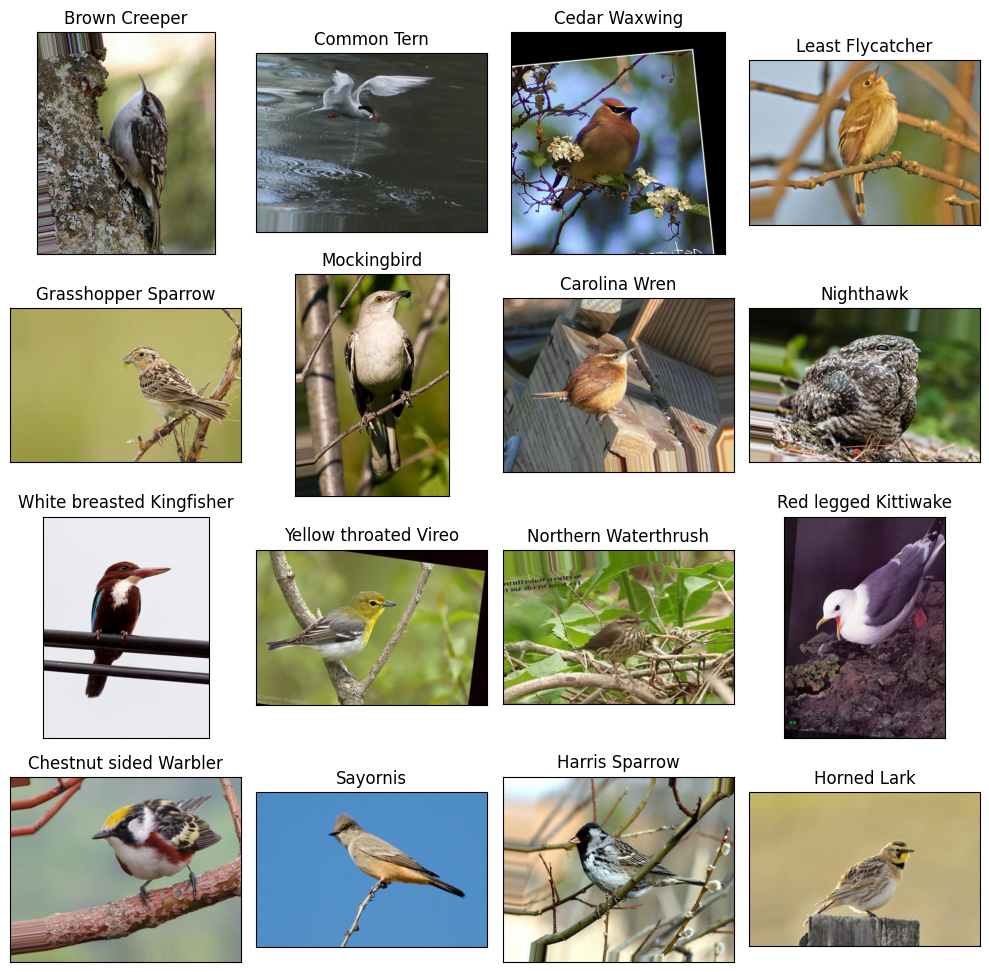

In [37]:
import numpy as np
import matplotlib.pyplot as plt

random_index = np.random.randint(0, len(df_aug), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_aug['Path'].iloc[random_index[i]]))
    ax.set_title(df_aug['Species'].iloc[random_index[i]])
plt.tight_layout()
plt.show()


# Подготовка данных к обучению

Оставим от датасетов только метки класса и путь к изображению птицы

In [38]:
X_train = df_train['Path']
y_train = df_train['Label']

X_val = df_val['Path']
y_val = df_val['Label']

X_test = df_test['Path']
y_test = df_test['Label']

In [39]:
X_train_aug = df_train_augmented['Path']
y_train_aug = df_train_augmented['Label']

In [40]:
X_train.tail()

8482    /kaggle/input/cub2002011/CUB_200_2011/images/1...
8483    /kaggle/input/cub2002011/CUB_200_2011/images/1...
8484    /kaggle/input/cub2002011/CUB_200_2011/images/1...
8485    /kaggle/input/cub2002011/CUB_200_2011/images/1...
8486    /kaggle/input/cub2002011/CUB_200_2011/images/1...
Name: Path, dtype: object

In [41]:
X_train_aug.tail()

49995    /kaggle/working/train_aug/Baltimore Oriole/aug...
49996    /kaggle/working/train_aug/Baltimore Oriole/aug...
49997    /kaggle/working/train_aug/Baltimore Oriole/aug...
49998    /kaggle/working/train_aug/Baltimore Oriole/aug...
49999    /kaggle/working/train_aug/Baltimore Oriole/aug...
Name: Path, dtype: object

При помощи аугментации изображений были сбалансированы классы. Теперь каждый класс представляет 100 изображений.

Создадим загрузчики данных для каждого датасета

In [42]:
print(f'Уникальных значений в train: {len(X_train_aug.unique())}')
print(f'Уникальных значений в val: {len(X_val.unique())}')
print(f'Уникальных значений в test: {len(X_test.unique())}')

Уникальных значений в train: 50000
Уникальных значений в val: 943
Уникальных значений в test: 2358


In [43]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [44]:
# Параметры генерации батчей
batch_size = 32
target_size = (224, 224)

# Генератор для обучающего набора (используем аугментированные данные)
train_images = train_generator.flow_from_dataframe(
    dataframe=df_train_augmented,
    x_col='Path',
    y_col='Species',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Генераторы для валидационного и тестового наборов
val_images = val_generator.flow_from_dataframe(
    dataframe=df_val,
    x_col='Path',
    y_col='Species',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='Path',
    y_col='Species',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size
)

Found 50000 validated image filenames belonging to 200 classes.
Found 943 validated image filenames belonging to 200 classes.
Found 2358 validated image filenames belonging to 200 classes.


# Настройка процессора перед обучением

Подключение графического процессора и использование его ресурсов для обучения модели позволит значительно сэкономить время.

In [45]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [46]:
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"Используется GPU: {device_name}")
else:
    print("GPU не найден, проверьте настройки среды исполнения!")

Используется GPU: /device:GPU:0


In [47]:
!nvidia-smi

Wed Feb 26 18:22:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P0             28W /   70W |     103MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [48]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Позволяет динамически выделять память
        print("GPU включен и настроен!")
    except RuntimeError as e:
        print(e)

GPU включен и настроен!


Тензорный процессор поможет оптимизировать обучение больших моделей, например, ViT.

In [49]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Определяем TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU подключён:", tpu.master())
except ValueError:
    print("TPU не найден!")

TPU не найден!


# Бейзлайн CNN-модель

Построим бейзлайн в виде простенькой сверточной нейросети, чтобы проверить данные и получить нижнюю границу оценки метрик. В качестве метрик возьмем точность и F1-score как более объективную.

In [50]:
input_shape = (224, 224, 3)

# Создаем простую CNN в качестве бейзлайна
def create_cnn_baseline(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2),
        
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2),

        tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),

        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

num_classes = len(train_images.class_indices)

baseline_model = create_cnn_baseline(input_shape, num_classes)

adam_optimizer = Adam(learning_rate=0.001)
baseline_model.compile(optimizer=adam_optimizer,
                       loss='categorical_crossentropy',
                       metrics=['accuracy', tf.metrics.F1Score(average='macro')])

baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 220, 220, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 220, 220, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 108, 108, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 108, 108, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 200)                 │         102,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 626,056 (2.39 MB)

 Trainable params: 625,096 (2.38 MB)

 Non-trainable params: 960 (3.75 KB)

Так как это бейзлайн модель, не будем заморачиваться с тонкой настройкой обучения.

In [51]:
# Настраиваем callback для TensorBoard
working_dir = '/kaggle/working'
log_dir = os.path.join(working_dir, "logs/fit/baseline", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_baseline_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [52]:
# Обучаем модель
steps_per_epoch = train_images.samples // train_images.batch_size
validation_steps = val_images.samples // val_images.batch_size

baseline_history = baseline_model.fit(
    train_images,
    #steps_per_epoch=steps_per_epoch,
    validation_data=val_images,
    #validation_steps=validation_steps,
    epochs=10,
    callbacks=[tensorboard_baseline_callback]
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 154s 84ms/step - accuracy: 0.0404 - f1_score: 0.0329 - loss: 4.8276 - val_accuracy: 0.0329 - val_f1_score: 0.0171 - val_loss: 6.6095
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 109s 70ms/step - accuracy: 0.1784 - f1_score: 0.1605 - loss: 3.5461 - val_accuracy: 0.1707 - val_f1_score: 0.1529 - val_loss: 3.8716
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 110s 70ms/step - accuracy: 0.3625 - f1_score: 0.3480 - loss: 2.5041 - val_accuracy: 0.1866 - val_f1_score: 0.1746 - val_loss: 3.9538
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 109s 69ms/step - accuracy: 0.5650 - f1_score: 0.5551 - loss: 1.6125 - val_accuracy: 0.2259 - val_f1_score: 0.2159 - val_loss: 4.3524
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 107s 68ms/step - accuracy: 0.7254 - f1_score: 0.7192 - loss: 0.9763 - val_accuracy: 0.2619 - val_f1_score: 0.2592 - val_loss: 4.2007
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 106s 68ms/step - accuracy: 0.8266 - f1_score: 0.8223 - loss: 0.6033 - val_accuracy:

In [53]:
results = baseline_model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))
print("Test Macro F1: {:.4f}".format(results[2]))

    Test Loss: 4.63175
Test Accuracy: 33.84%
Test Macro F1: 0.3362


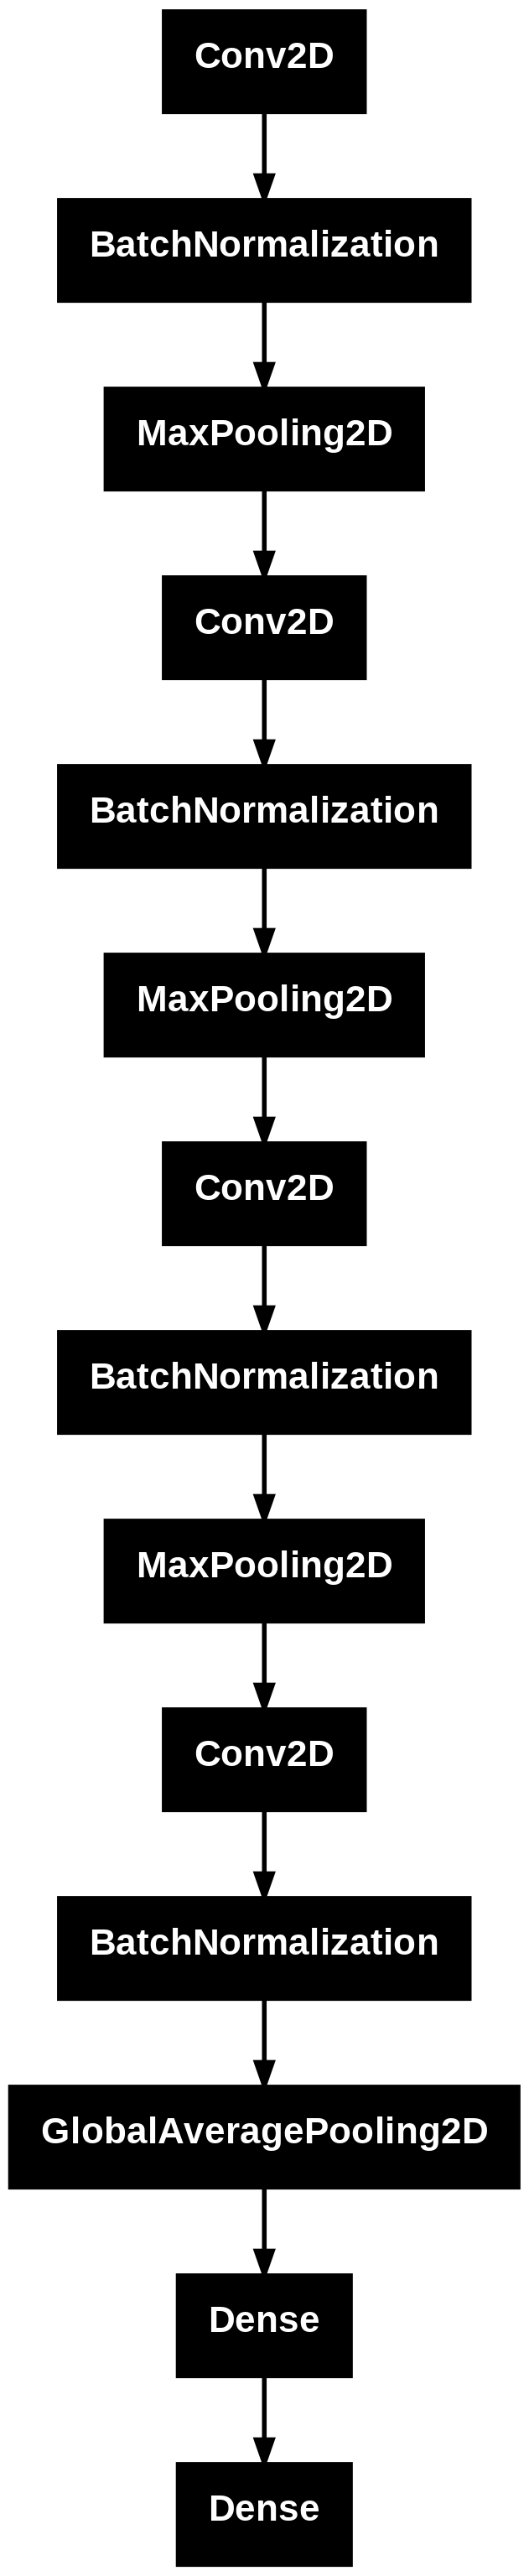

In [72]:
plot_model(baseline_model, to_file='baseline_model.png')

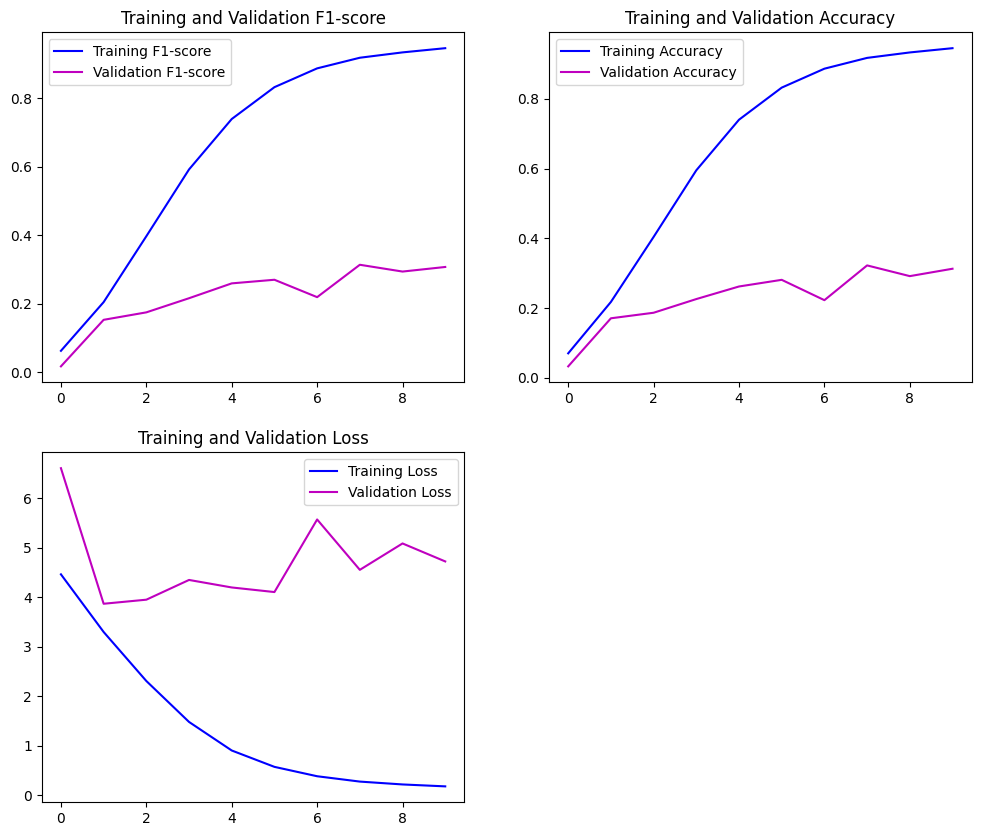

In [54]:
accuracy = baseline_history.history['accuracy']
f1 = baseline_history.history['f1_score']
val_accuracy = baseline_history.history['val_accuracy']
val_f1 = baseline_history.history['val_f1_score']
loss = baseline_history.history['loss']
val_loss = baseline_history.history['val_loss']

epochs_range = range(len(accuracy))

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs_range, f1, 'b', label='Training F1-score')
plt.plot(epochs_range, val_f1, 'm', label='Validation F1-score')
plt.title('Training and Validation F1-score')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs_range, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, 'm', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs_range, loss, 'b', label='Training Loss')
plt.plot(epochs_range, val_loss, 'm', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()


plt.show()

In [55]:
baseline_model.save('baseline_model.keras')

# Улучшаем модель

Попробуем добавить дропаут-слой после слоев свертки и пулинга, чтобы побороть переобучение

In [56]:
input_shape = (224, 224, 3)

dropout_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

num_classes = len(train_images.class_indices)

adam_optimizer = Adam(learning_rate=0.001)
dropout_model.compile(optimizer=adam_optimizer,
                       loss='categorical_crossentropy',
                       metrics=['accuracy', tf.metrics.F1Score(average='macro')])

dropout_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 220, 220, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 220, 220, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 108, 108, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 108, 108, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 200)                 │         102,6

 Total params: 626,056 (2.39 MB)

 Trainable params: 625,096 (2.38 MB)

 Non-trainable params: 960 (3.75 KB)

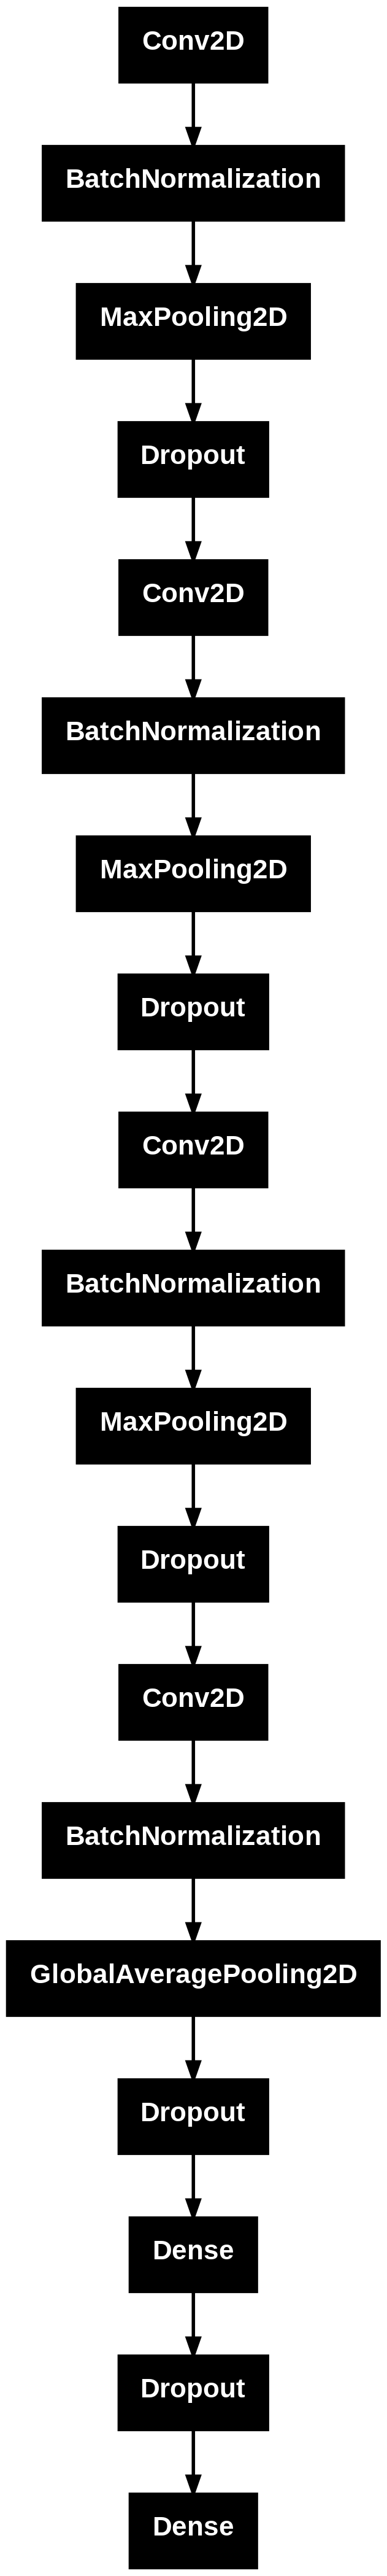

In [73]:
plot_model(dropout_model, to_file='dropout_model.png')

In [57]:
# Настраиваем callback для TensorBoard
working_dir = '/kaggle/working'
log_dir = os.path.join(working_dir, "logs/fit/dropout", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_dropout_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [58]:
# Обучаем модель
dropout_history = dropout_model.fit(
    train_images,
    #steps_per_epoch=len(train_images),
    validation_data=val_images,
    #validation_steps=len(val_images),
    epochs=20,
    callbacks=[tensorboard_baseline_callback]
)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 124s 72ms/step - accuracy: 0.0217 - f1_score: 0.0179 - loss: 5.1364 - val_accuracy: 0.0032 - val_f1_score: 5.2448e-05 - val_loss: 13.6842
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 106s 67ms/step - accuracy: 0.0619 - f1_score: 0.0527 - loss: 4.4572 - val_accuracy: 0.0785 - val_f1_score: 0.0598 - val_loss: 4.6588
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 105s 67ms/step - accuracy: 0.1235 - f1_score: 0.1083 - loss: 3.9483 - val_accuracy: 0.1007 - val_f1_score: 0.0804 - val_loss: 4.4859
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 104s 67ms/step - accuracy: 0.1812 - f1_score: 0.1656 - loss: 3.5412 - val_accuracy: 0.1930 - val_f1_score: 0.1725 - val_loss: 3.5932
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 105s 67ms/step - accuracy: 0.2402 - f1_score: 0.2251 - loss: 3.2177 - val_accuracy: 0.1835 - val_f1_score: 0.1697 - val_loss: 3.8128
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 106s 68ms/step - accuracy: 0.2913 - f1_score: 0.2764 - loss: 2.9398 - val_accu

In [59]:
results = dropout_model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))
print("Test Macro F1: {:.4f}".format(results[2]))

    Test Loss: 2.81785
Test Accuracy: 42.07%
Test Macro F1: 0.4240


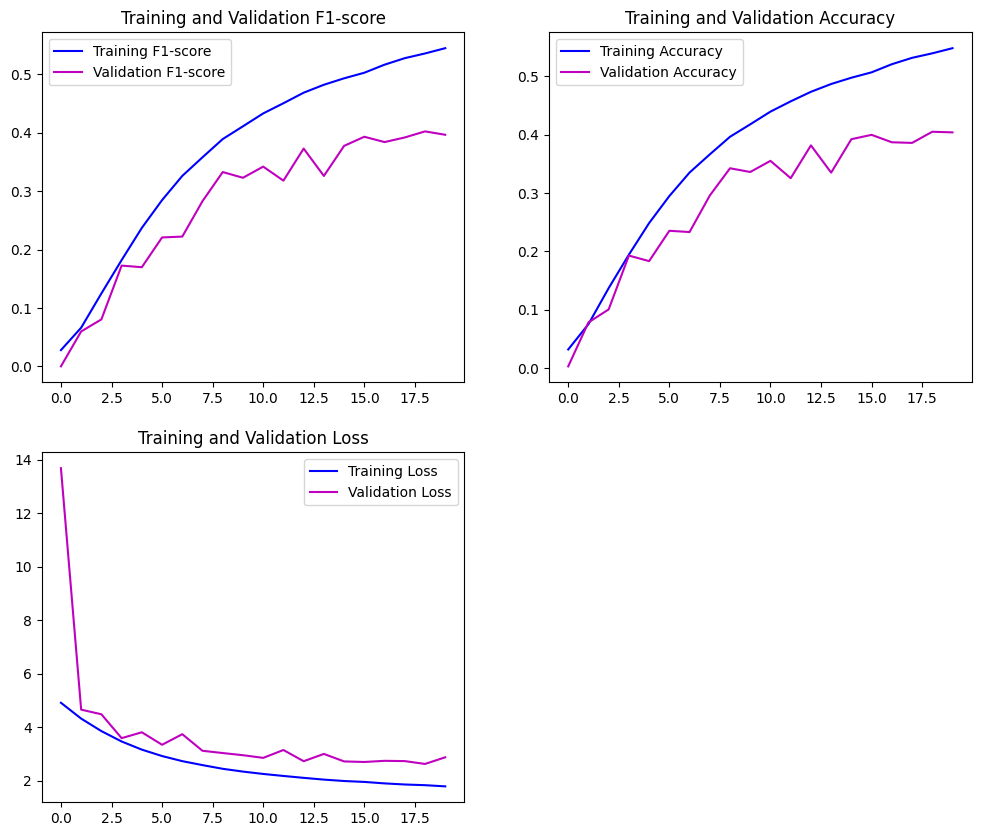

In [60]:
accuracy = dropout_history.history['accuracy']
f1 = dropout_history.history['f1_score']
val_accuracy = dropout_history.history['val_accuracy']
val_f1 = dropout_history.history['val_f1_score']
loss = dropout_history.history['loss']
val_loss = dropout_history.history['val_loss']

epochs_range = range(len(accuracy))

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs_range, f1, 'b', label='Training F1-score')
plt.plot(epochs_range, val_f1, 'm', label='Validation F1-score')
plt.title('Training and Validation F1-score')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs_range, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, 'm', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs_range, loss, 'b', label='Training Loss')
plt.plot(epochs_range, val_loss, 'm', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()


plt.show()

In [61]:
dropout_model.save('dropout_model.keras')

# Transfer Learning на основе EfficientNetB0

In [62]:
enet_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
enet_model.trainable = False

inputs = enet_model.input
x = Dense(128, activation='relu')(enet_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)

num_classes = len(train_images.class_indices)
outputs = Dense(num_classes, activation='softmax')(x)

tl_model = Model(inputs=inputs, outputs=outputs)

tl_model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.metrics.F1Score(average='macro')]
)

tl_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_2 (Cast)             │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ cast_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce    

 Total params: 4,297,963 (16.40 MB)

 Trainable params: 248,392 (970.28 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Настроим колбэки для более тонкой настройки обучения модели:

In [63]:

# Установим сохранение весов модели
checkpoint_path = os.path.join(working_dir, "logs", "birds_classification_model_checkpoint.weights.h5")
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

log_dir = os.path.join(working_dir, "logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Установим колбэк для ранней остановки обучения модели
early_stopping = EarlyStopping(
    monitor="val_loss",  # Ориентируемся на val_loss
    patience=5, # Если val_loss снижается 5 эпох подряд, обучение окончится преждевременно
    restore_best_weights=True
)

# Колбэк для уменьшения скорости обучения при плато
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

In [64]:
history = tl_model.fit(
    train_images,
    epochs=150,
    validation_data=val_images,
    callbacks=[
        early_stopping,
        tensorboard_callback,
        checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/150
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 165s 89ms/step - accuracy: 0.0088 - f1_score: 0.0064 - loss: 6.2037 - val_accuracy: 0.0721 - val_f1_score: 0.0300 - val_loss: 4.7991 - learning_rate: 1.0000e-04
Epoch 2/150
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 108s 69ms/step - accuracy: 0.0458 - f1_score: 0.0310 - loss: 4.8420 - val_accuracy: 0.1951 - val_f1_score: 0.1359 - val_loss: 3.8221 - learning_rate: 1.0000e-04
Epoch 3/150
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 107s 68ms/step - accuracy: 0.0933 - f1_score: 0.0754 - loss: 4.2897 - val_accuracy: 0.2853 - val_f1_score: 0.2194 - val_loss: 3.2146 - learning_rate: 1.0000e-04
Epoch 4/150
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 108s 69ms/step - accuracy: 0.1422 - f1_score: 0.1227 - loss: 3.8500 - val_accuracy: 0.3659 - val_f1_score: 0.3195 - val_loss: 2.7439 - learning_rate: 1.0000e-04
Epoch 5/150
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 106s 68ms/step - accuracy: 0.1804 - f1_score: 0.1637 - loss: 3.5140 - val_accuracy: 0.4072 - val_f1_score: 0.3639 - val_loss: 2.4155 - learni

In [65]:
results = tl_model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))
print("Test Macro F1: {:.4f}".format(results[2]))

    Test Loss: 1.27854
Test Accuracy: 65.69%
Test Macro F1: 0.6560


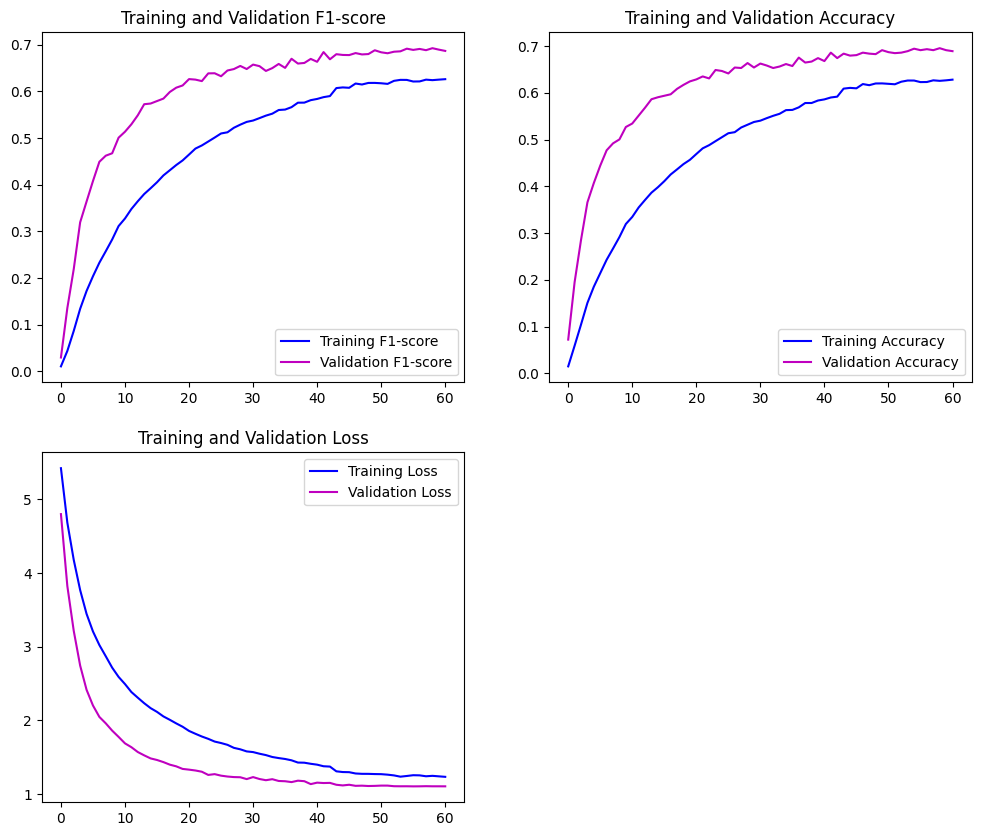

In [66]:
accuracy = history.history['accuracy']
f1 = history.history['f1_score']
val_accuracy = history.history['val_accuracy']
val_f1 = history.history['val_f1_score']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(accuracy))

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs_range, f1, 'b', label='Training F1-score')
plt.plot(epochs_range, val_f1, 'm', label='Validation F1-score')
plt.title('Training and Validation F1-score')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs_range, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, 'm', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs_range, loss, 'b', label='Training Loss')
plt.plot(epochs_range, val_loss, 'm', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()


plt.show()

In [68]:
tl_model.save('enet_model.keras')